# Import package and data

In [1]:
## Import package
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import igraph as ig
import time
import numpy as np
import math
import louvain
import matplotlib.image as mpimg
import seaborn as sns

/var/folders/6n/cshchkt15ws55nrl6c61wq700000gn/T/ipykernel_74268/4239586725.py:10: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
# Load the dataset
df = pd.read_csv('netflix_titles.csv')
# Convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'], infer_datetime_format=True, errors='coerce')
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

# Convert columns to lists
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

# remove null director

df = df[df.director.notnull()]

/var/folders/6n/cshchkt15ws55nrl6c61wq700000gn/T/ipykernel_74268/2304331147.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date_added"] = pd.to_datetime(df['date_added'], infer_datetime_format=True, errors='coerce')


In [3]:
# Filter films produced in the USA
usa = df[df['countries'].apply(lambda x: 'United States' in x)]
usa = usa[usa.type == "Movie"]
usa.shape

(2684, 19)

In [31]:
## utils function

def clustering_func(graph_netx, algo, resolution=1):
  graph = ig.Graph.from_networkx(graph_netx)

  if algo == "multilevel":
    cl = graph.community_multilevel(resolution=resolution)
  elif algo == "leiden_mod":
    cl = graph.community_leiden(objective_function="modularity",resolution=resolution)
  elif algo == "leiden_cpm":
    cl = graph.community_leiden(objective_function="CPM", resolution=resolution)
  elif algo == "infomap":
    cl = graph.community_infomap(trials=20)

  membership = cl.membership
  np_membership = np.array(membership)

  # Get a tuple of unique clusters & their frequency in numpy array
  uniqueClusters, occurCount = np.unique(np_membership, return_counts=True)
  print('In the network there are ', len(uniqueClusters), ' clusters.')

  # Zip both the arrays
  #listOfUniqueClusters = zip(uniqueClusters, occurCount)
  # print('Unique Clusters along with occurrence Count')
  # Iterate over the zip object
  #for elem in listOfUniqueClusters:
  #  print('Cluster No: ', elem[0] , ' Contains : ' , elem[1], ' nodes')

  modularity = graph.modularity(membership)
  print("The modularity for the",algo, "algorithm is {}".format(format(modularity, '.2f')))

  # Summary
  summary = [len(uniqueClusters), modularity]

  return cl, summary

def cluster_plot(graph_netx, cluster, algo, size, filename, show_labels=False):
  
  """
  Kamada-Kawai layout: 'kk'
  Fruchterman-Reingold layout: 'fr'
  DRL layout: 'drl'
  """
  graph = ig.Graph.from_networkx(graph_netx)
  # Calculate betweenness
  betweenness = graph.betweenness(weights=None)

  # Define style from network plotting
  visual_style = {}
  visual_style["mark_groups"] = True
  visual_style["vertex_size"] = [7 + v * 0.0001 for v in betweenness]
  visual_style["edge_width"] = 1
  visual_style["layout"] = algo
  visual_style["bbox"] = (size,size)
  visual_style["margin"] = 20

  if show_labels == True:
    visual_style["vertex_label"] = graph.vs["label"]
    visual_style["vertex_label_size"]=8
  else:
    visual_style["vertex_label"] = None

  # Save Graph
  out = ig.plot(cluster, **visual_style)
  out.save(filename)

  # Read and show Graph
  plt.figure(figsize=(12,12))
  img=mpimg.imread(filename)
  plt.axis('off')
  plt.imshow(img)



def create_graph_by_actor_genre(data, genre=None, genre_filter=True):
    if genre_filter and genre:
        data_genre = data[data['categories'].apply(lambda x: genre in x)]
    else:
        data_genre = data.copy()
    
    graph_actor = nx.Graph()
    for _, row in data_genre.iterrows():
        actors = row['actors']
        graph_actor.add_nodes_from(actors)  # Add all actors as nodes

        # Add edges between actors in the same project
        for i in range(len(actors)):
            for j in range(i + 1, len(actors)):
                graph_actor.add_edge(actors[i], actors[j])

    return graph_actor


def create_sub_graph(graph, node_threshold):
   # Get nodes with more than 5 connections
  selected_nodes = [node for node, degree in graph.degree() if degree >= node_threshold]

    # Create a subgraph containing selected nodes and their neighbors
  subgraph = graph.subgraph(selected_nodes).copy()   
  return subgraph




def create_feature_table_for_actor(data, genre):
  data_genre = data[data['categories'].apply(lambda x: genre in x)]

  data_genre_unlist = data_genre.explode('actors').reset_index(drop=True)
   
  data_genre_unlist['duration'] = data_genre_unlist.duration.str.replace(' min', '').astype(float)

  data_genre_group = (data_genre_unlist
                       .groupby('actors')
                       .agg({'show_id':'nunique', 'director':'nunique', 'rating':'nunique', 'duration':'mean'})
                       .reset_index())
   
  data_genre_group.columns = ['actors', 'num_movie', 'num_director', 'num_rating_unique', 'avg_duration']

  return data_genre_group


def node_community(cluster_result):
  community = cluster_result.membership
  nodes = cluster_result.graph.vs['_nx_name']
  node_community_data = pd.DataFrame({'nodes':nodes,
                                        'community':community})
   
  return node_community_data


def graph_measure(cluster_result):
  nodes = cluster_result.graph.vs['_nx_name']
  degree = cluster_result.graph.degree()
  closeness = cluster_result.graph.closeness()
  betweenness = cluster_result.graph.betweenness()
  eigenvector = cluster_result.graph.eigenvector_centrality()
  centrality_data = pd.DataFrame({'nodes':nodes,
                                   'degree':degree,
                                   'closeness':closeness,
                                   'betweenness': betweenness,
                                   'eigenvector':eigenvector})
  return centrality_data



def community_proportion(cluster_results, top_community=10, top_genre=5):
    actor_genre = usa[['categories', 'actors']].explode(['categories']).explode('actors').reset_index(drop=True)
    node_community_all = node_community(cluster_results)
    community_count_actors = node_community_all.community.value_counts().reset_index()
    community_top = community_count_actors.head(top_community)['community']
    genre_top = actor_genre.groupby('categories')['actors'].agg('nunique').reset_index().sort_values('actors', ascending=False).head(top_genre)['categories']

    df_genre_commnunity = pd.DataFrame(columns=['categories', 'actors', 'community'])

    for community_val in community_top:
        df = (actor_genre[actor_genre.actors.isin(node_community_all[node_community_all.community==community_val]['nodes'])]
              .groupby('categories')
              .agg({'actors':'nunique'})
              .reset_index()
              .sort_values('actors', ascending=False)
        )


        df['community'] = community_val

        df = df[df.categories.isin(genre_top)]

        df_genre_commnunity = pd.concat([df_genre_commnunity, df])

    df_genre_commnunity = df_genre_commnunity.merge(community_count_actors, on = 'community', how='inner')

    df_genre_commnunity['actors_percentage'] = pd.to_numeric(df_genre_commnunity['actors']/df_genre_commnunity['count'])
    
    pivot_df = df_genre_commnunity.pivot_table(index='community', columns='categories', values='actors_percentage', aggfunc='mean')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, cmap='coolwarm', fmt=".1f", linewidths=.5)
    plt.xlabel('Genre')
    plt.ylabel('Community')
    plt.show()

    return df_genre_commnunity


def change_graph_edge(graph, prop):
  g_change = graph.copy()
  # Define the fraction of edges to permute
  fraction_to_permute = prop  # e.g., 10% of the edges

# Get all edges
  all_edges = np.array(g_change.get_edgelist())

# Determine the number of edges to permute
  num_edges_to_permute = int(len(all_edges) * fraction_to_permute)

# Randomly select edges to permute
  selected_edges_idx = np.random.choice(len(all_edges), num_edges_to_permute, replace=False)
  selected_edges = all_edges[selected_edges_idx]

# Generate new random connections for these selected edges
# Ensure that no self-loops are created and preserve the graph's properties (like being simple, if it was)
  while True:
      np.random.shuffle(selected_edges[:, 0:1])  # Only shuffle the target to avoid self-loops
      if not any(selected_edges[:, 0] == selected_edges[:, 1]):
        break

# Remove the original edges that are selected for permutation
  g_change.delete_edges(selected_edges_idx)

# Add the newly permuted edges
  g_change.add_edges(selected_edges)

  return g_change


# Graph data for actors

In [5]:
full_graph_actor = create_graph_by_actor_genre(usa, False)

In [6]:
full_graph_actor.number_of_nodes()

11686

In [7]:
full_graph_actor.number_of_edges()

94964

# Community detection

In [8]:
## Using Louvain and Leiden method for community detection
g_louvain_1, g_louvain_sum_1 = clustering_func(full_graph_actor, "multilevel")
g_leiden_mod_1, g_leiden_mod_sum_1 = clustering_func(full_graph_actor, "leiden_mod")

In the network there are  345  clusters.
The modularity for the multilevel algorithm is 0.62
In the network there are  345  clusters.
The modularity for the leiden_mod algorithm is 0.63


In [9]:
## Using Louvain and Leiden method for community detection
g_louvain_2, g_louvain_sum_2 = clustering_func(full_graph_actor, "multilevel", resolution=1.5)
g_leiden_mod_2, g_leiden_mod_sum_2 = clustering_func(full_graph_actor, "leiden_mod", resolution=1.5)

In the network there are  374  clusters.
The modularity for the multilevel algorithm is 0.62
In the network there are  370  clusters.
The modularity for the leiden_mod algorithm is 0.62


In [10]:
## Using Louvain and Leiden method for community detection
g_louvain_3, g_louvain_sum_3 = clustering_func(full_graph_actor, "multilevel", resolution=0.9)
g_leiden_mod_3, g_leiden_mod_sum_3 = clustering_func(full_graph_actor, "leiden_mod", resolution=0.9)

In the network there are  341  clusters.
The modularity for the multilevel algorithm is 0.62
In the network there are  342  clusters.
The modularity for the leiden_mod algorithm is 0.63


In [21]:
## Compare community structures using nmi
ig.compare_communities(g_louvain_1, g_leiden_mod_1, method='nmi')

0.6626648037502878

In [22]:
## Compare community structures using nmi
ig.compare_communities(g_louvain_2, g_leiden_mod_2, method='nmi')

0.718969429363851

In [23]:
ig.compare_communities(g_louvain_3, g_leiden_mod_3, method='nmi')

0.6290455325154929

In [42]:
## Detection of degeneracy in the Multilevel community structure

mod_list_lvn =[]
comm_list_lvn = []
memb_list_lvn = []
perm_list=[]

comm_list_lvn.append(g_leiden_mod_1)
memb_list_lvn.append(g_leiden_mod_1.membership)
mod_list_lvn.append(g_leiden_mod_1.modularity)

nodes = ig.Graph.from_networkx(full_graph_actor).vcount()

for i in range(1,6):
  perm_sim = change_graph_edge(ig.Graph.from_networkx(full_graph_actor), prop=0.01)

  com = perm_sim.community_multilevel(resolution=1, return_levels=False)

  a = node_community(com)
  a = a.sort_values(by='nodes')
  memb_list_lvn.append(a.loc[:,'community'].values)

  mod_list_lvn.append(com.modularity)
  comm_list_lvn.append(com)

In [52]:
for i in range(0,5):
  for j in range(i+1,6):
    rand=ig.compare_communities(comm_list_lvn[i], comm_list_lvn[j], 'rand')
    nmi = ig.compare_communities(comm_list_lvn[i], comm_list_lvn[j], 'nmi')
    print(f'Comparing permutations {i} and {j}, nmi={nmi}, rand = {rand}')

Comparing permutations 0 and 1, nmi=0.6361558926818659, rand = 0.9694266409502507
Comparing permutations 0 and 2, nmi=0.6453249975286746, rand = 0.9701597448160544
Comparing permutations 0 and 3, nmi=0.665803026086378, rand = 0.9718647499309965
Comparing permutations 0 and 4, nmi=0.627111756518612, rand = 0.9682463485596691
Comparing permutations 0 and 5, nmi=0.6192611825149062, rand = 0.9671475056445981
Comparing permutations 1 and 2, nmi=0.6389059773057875, rand = 0.9707860313783335
Comparing permutations 1 and 3, nmi=0.6294580275322986, rand = 0.9714964477351341
Comparing permutations 1 and 4, nmi=0.6235469504701254, rand = 0.9699813205199438
Comparing permutations 1 and 5, nmi=0.6165442928832615, rand = 0.9685979536862843
Comparing permutations 2 and 3, nmi=0.63070838297728, rand = 0.9722091636005941
Comparing permutations 2 and 4, nmi=0.6202733343962871, rand = 0.9700457214089604
Comparing permutations 2 and 5, nmi=0.6146607309791335, rand = 0.9677872816812426
Comparing permutatio

In [54]:
mod_list_lvn

[0.6287785362649374,
 0.6154284028454571,
 0.6158824141306414,
 0.6163759387920353,
 0.6139392518911537,
 0.6146776247458229]

In [55]:
## Detection of degeneracy in the Multilevel community structure

mod_list_lvn =[]
comm_list_lvn = []
memb_list_lvn = []
perm_list=[]

comm_list_lvn.append(g_leiden_mod_1)
memb_list_lvn.append(g_leiden_mod_1.membership)
mod_list_lvn.append(g_leiden_mod_1.modularity)

nodes = ig.Graph.from_networkx(full_graph_actor).vcount()

for i in range(1,6):
  perm_sim = change_graph_edge(ig.Graph.from_networkx(full_graph_actor), prop=0.05)

  com = perm_sim.community_multilevel(resolution=1, return_levels=False)

  a = node_community(com)
  a = a.sort_values(by='nodes')
  memb_list_lvn.append(a.loc[:,'community'].values)

  mod_list_lvn.append(com.modularity)
  comm_list_lvn.append(com)

In [56]:
for i in range(0,5):
  for j in range(i+1,6):
    rand=ig.compare_communities(comm_list_lvn[i], comm_list_lvn[j], 'rand')
    nmi = ig.compare_communities(comm_list_lvn[i], comm_list_lvn[j], 'nmi')
    print(f'Comparing permutations {i} and {j}, nmi={nmi}, rand = {rand}')

Comparing permutations 0 and 1, nmi=0.5972111535088012, rand = 0.9656870393613635
Comparing permutations 0 and 2, nmi=0.585079460501754, rand = 0.9602113966139075
Comparing permutations 0 and 3, nmi=0.6077164590693391, rand = 0.9688595118113822
Comparing permutations 0 and 4, nmi=0.6061880095436656, rand = 0.9688898594670661
Comparing permutations 0 and 5, nmi=0.5847298545852729, rand = 0.9650776109804029
Comparing permutations 1 and 2, nmi=0.5414476596945863, rand = 0.9590305769474551
Comparing permutations 1 and 3, nmi=0.5497456198858144, rand = 0.9656494709555578
Comparing permutations 1 and 4, nmi=0.5611031366626587, rand = 0.967377646915718
Comparing permutations 1 and 5, nmi=0.5384242954952112, rand = 0.9636742223101991
Comparing permutations 2 and 3, nmi=0.5371172368499436, rand = 0.9604889048341017
Comparing permutations 2 and 4, nmi=0.5432270765351036, rand = 0.9613794737801454
Comparing permutations 2 and 5, nmi=0.5217901910267814, rand = 0.9589406031786972
Comparing permutat

In [57]:
mod_list_lvn

[0.6287785362649374,
 0.591194161315875,
 0.5934853628504011,
 0.5917731347150664,
 0.5925156606890659,
 0.5924603466418203]

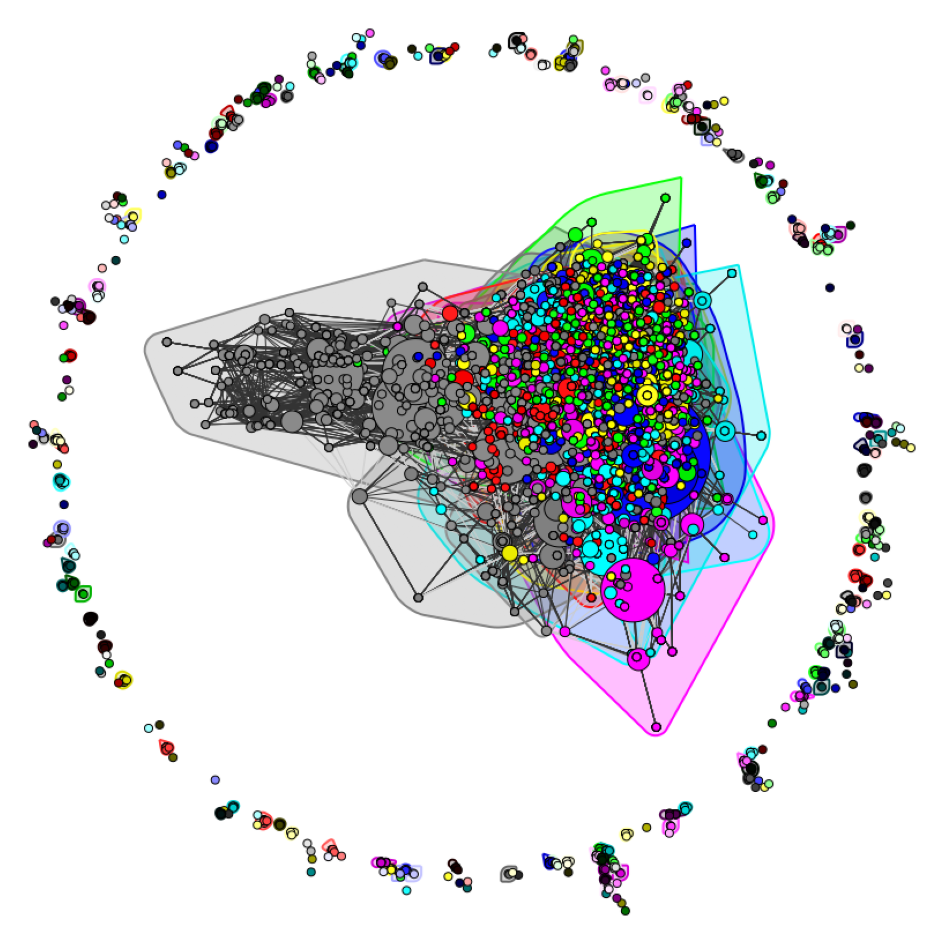

In [16]:
## plot leiden
cluster_plot(full_graph_actor, g_leiden_mod_1, "mds", 800, "images/g_leiden_mds.png")

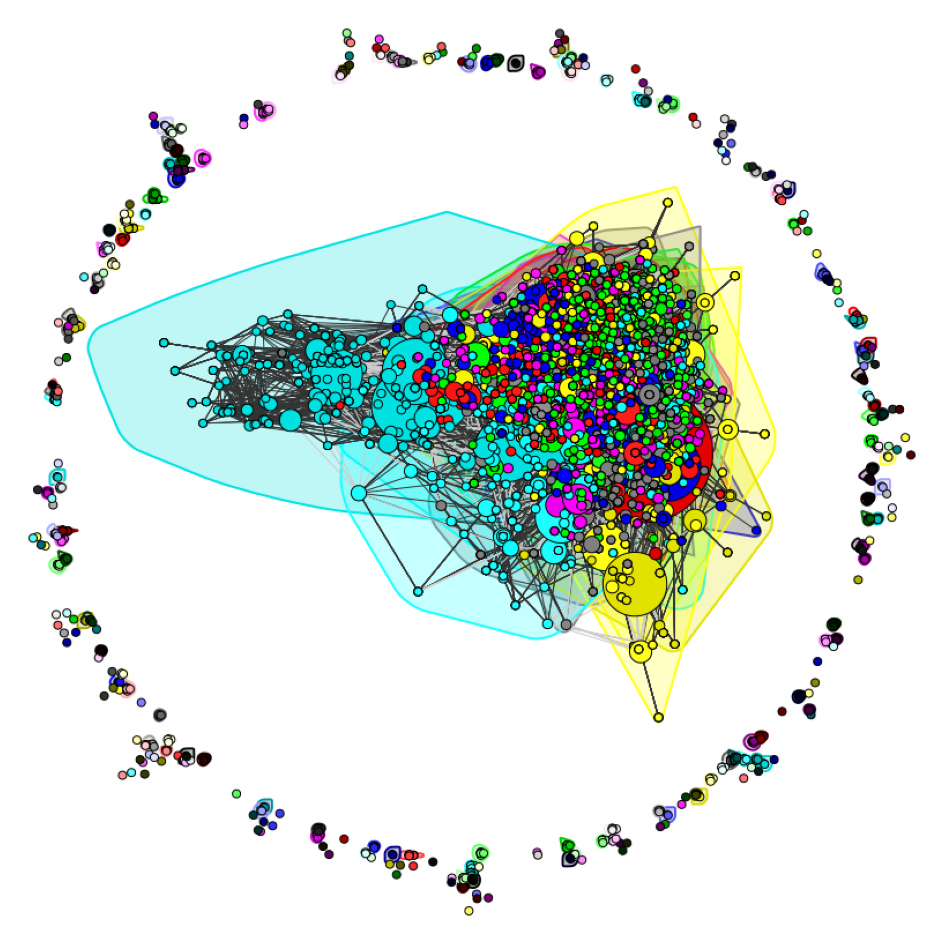

In [17]:
cluster_plot(full_graph_actor, g_louvain_1, "mds", 800, "images/g_louvain_mds.png")

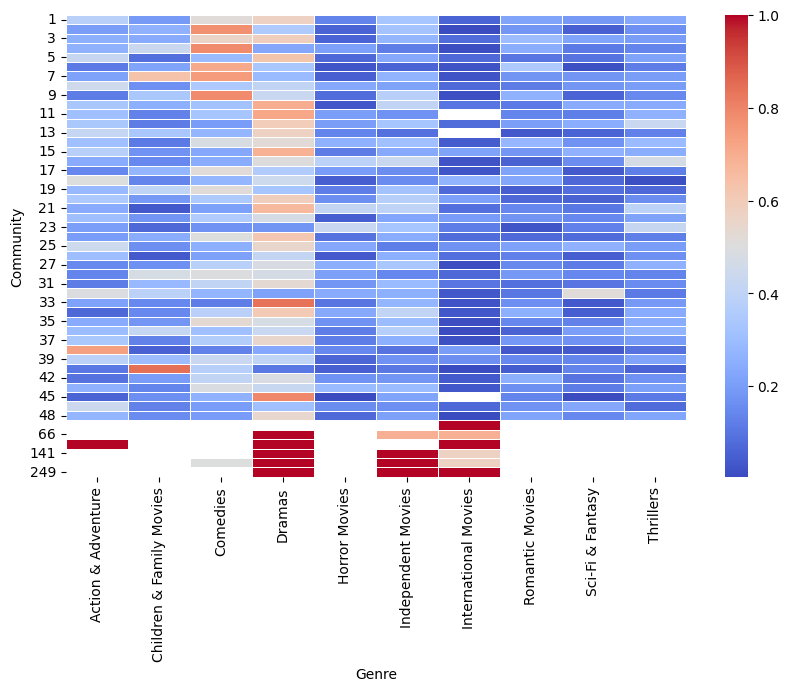

,categories,actors,community,count,actors_percentage
0,Dramas,553,1,960,0.576042
1,Comedies,496,1,960,0.516667
2,Action & Adventure,364,1,960,0.379167
3,Independent Movies,317,1,960,0.330208
4,Thrillers,227,1,960,0.236458
...,...,...,...,...,...
439,International Movies,8,161,14,0.571429
440,Comedies,7,161,14,0.500000
441,Dramas,13,66,13,1.000000
442,Independent Movies,9,66,13,0.692308


In [37]:
community_proportion(g_louvain_1, top_community=50, top_genre=10)

## Graph for genre Action & Adventure

In [63]:
graph_action = create_graph_by_actor_genre(usa, 'Action & Adventure', True)
feature_table_action = create_feature_table_for_actor(usa, 'Action & Adventure')

In [67]:
## community detection
g_louvain_action_1, g_louvain_sum_action = clustering_func(graph_action, "multilevel", resolution=1)
g_leiden_action_1, g_leiden_sum_action = clustering_func(graph_action, "leiden_mod", resolution=1)

In the network there are  55  clusters.
The modularity for the multilevel algorithm is 0.78
In the network there are  59  clusters.
The modularity for the leiden_mod algorithm is 0.78


In [70]:
ig.compare_communities(g_louvain_action_1, g_leiden_action_1, method='nmi')

0.8125922153541201

In [71]:
## community detection
g_louvain_action_2, g_louvain_sum_action_2 = clustering_func(graph_action, "multilevel", resolution=1.5)
g_leiden_action_2, g_leiden_sum_action_2 = clustering_func(graph_action, "leiden_mod", resolution=1.5)

In the network there are  67  clusters.
The modularity for the multilevel algorithm is 0.77
In the network there are  68  clusters.
The modularity for the leiden_mod algorithm is 0.78


In [72]:
ig.compare_communities(g_louvain_action_2, g_leiden_action_2, method='nmi')

0.7974509468764148

In [73]:
## community detection
g_louvain_action_3, g_louvain_sum_action_3 = clustering_func(graph_action, "multilevel", resolution=0.9)
g_leiden_action_3, g_leiden_sum_action_3 = clustering_func(graph_action, "leiden_mod", resolution=0.9)

In the network there are  54  clusters.
The modularity for the multilevel algorithm is 0.78
In the network there are  53  clusters.
The modularity for the leiden_mod algorithm is 0.78


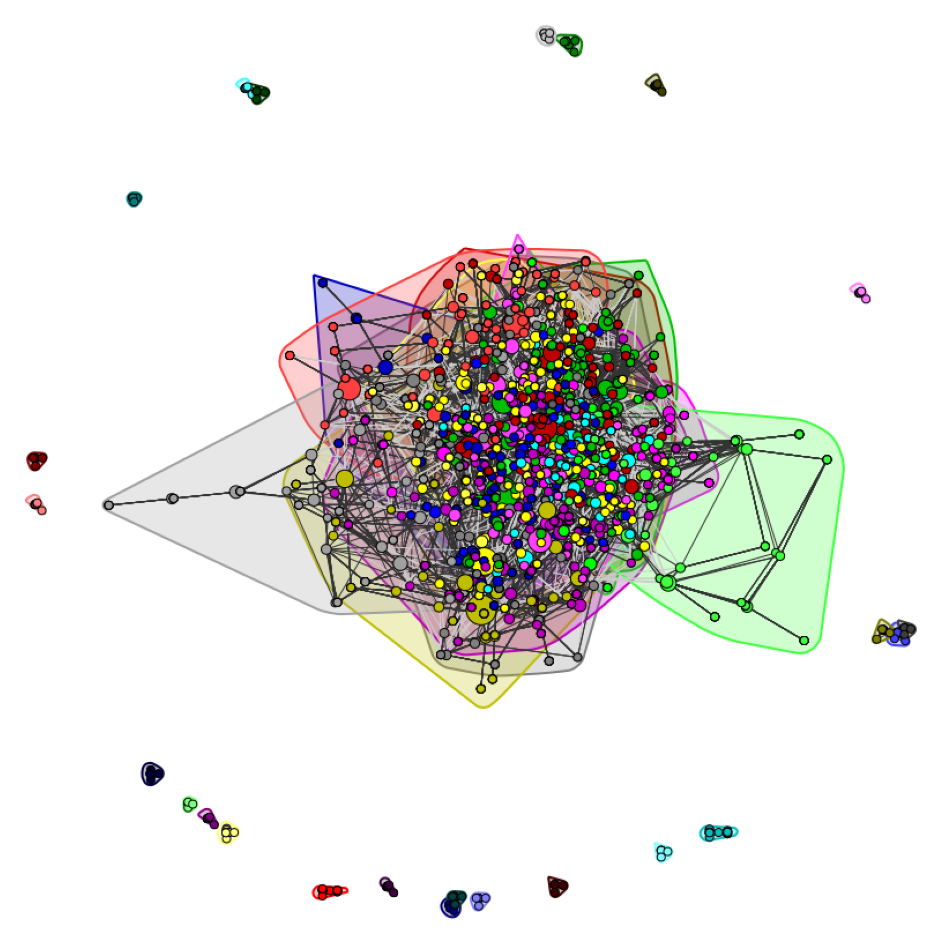

In [65]:
## plot louvain
cluster_plot(graph_action, g_louvain_action_1, "mds", 800, "images/g_louvain_mds_action.png")

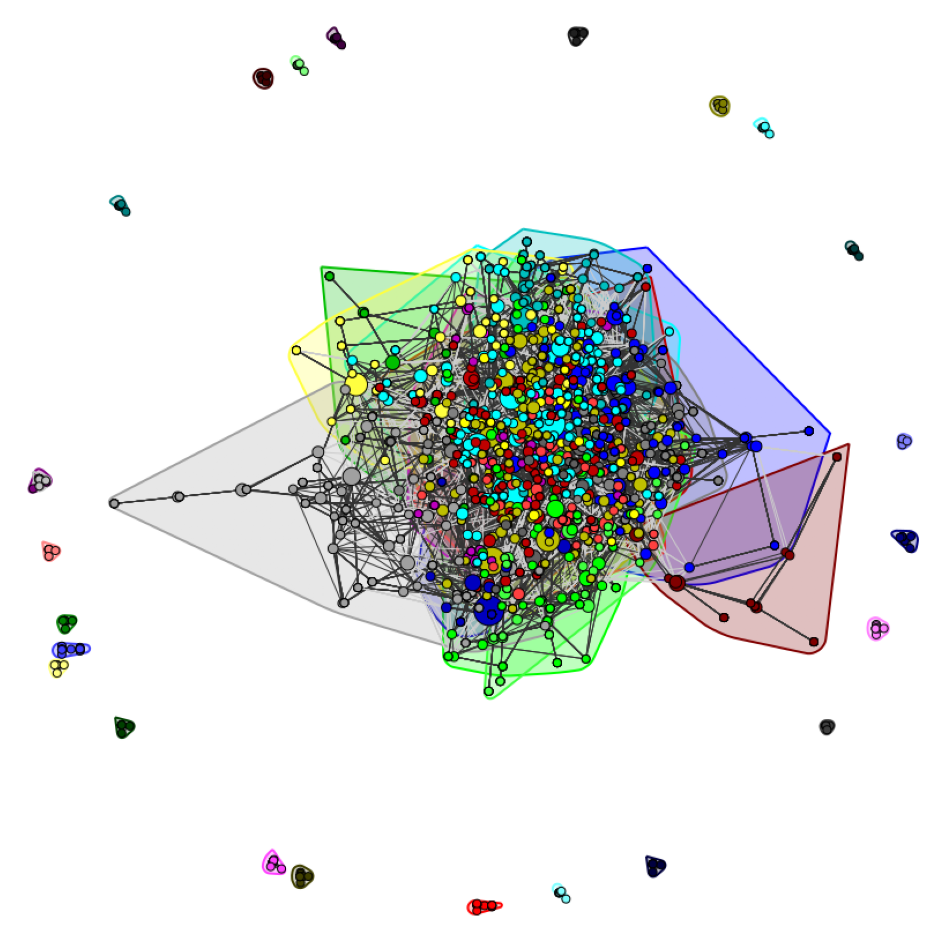

In [66]:
## plot leiden
cluster_plot(graph_action, g_louvain_action_1, "mds", 800, "images/g_leiden_mds_action.png")

## Graph for genre Dramas

In [79]:
graph_dramas = create_graph_by_actor_genre(usa, 'Dramas', True)
feature_table_dramas = create_feature_table_for_actor(usa, 'Dramas')

In [80]:
## community detection
g_louvain_dramas_1, g_louvain_sum_dramas_1 = clustering_func(graph_dramas, "multilevel", resolution=1)
g_leiden_dramas_1, g_leiden_sum_dramas_1 = clustering_func(graph_dramas, "leiden_mod", resolution=1)


In the network there are  128  clusters.
The modularity for the multilevel algorithm is 0.74
In the network there are  127  clusters.
The modularity for the leiden_mod algorithm is 0.74


In [81]:
## community detection
g_louvain_dramas_2, g_louvain_sum_dramas_2 = clustering_func(graph_dramas, "multilevel", resolution=1.5)
g_leiden_dramas_2, g_leiden_sum_dramas_2 = clustering_func(graph_dramas, "leiden_mod", resolution=1.5)

In the network there are  142  clusters.
The modularity for the multilevel algorithm is 0.74
In the network there are  139  clusters.
The modularity for the leiden_mod algorithm is 0.74


In [82]:
## community detection
g_louvain_dramas_3, g_louvain_sum_dramas_3 = clustering_func(graph_dramas, "multilevel", resolution=0.9)
g_leiden_dramas_3, g_leiden_sum_dramas_3 = clustering_func(graph_dramas, "leiden_mod", resolution=0.9)

In the network there are  126  clusters.
The modularity for the multilevel algorithm is 0.74
In the network there are  123  clusters.
The modularity for the leiden_mod algorithm is 0.75


In [83]:
## plot louvain
cluster_plot(graph_dramas, g_louvain_dramas_1, "mds", 800, "images/g_louvain_mds_dramas.png")

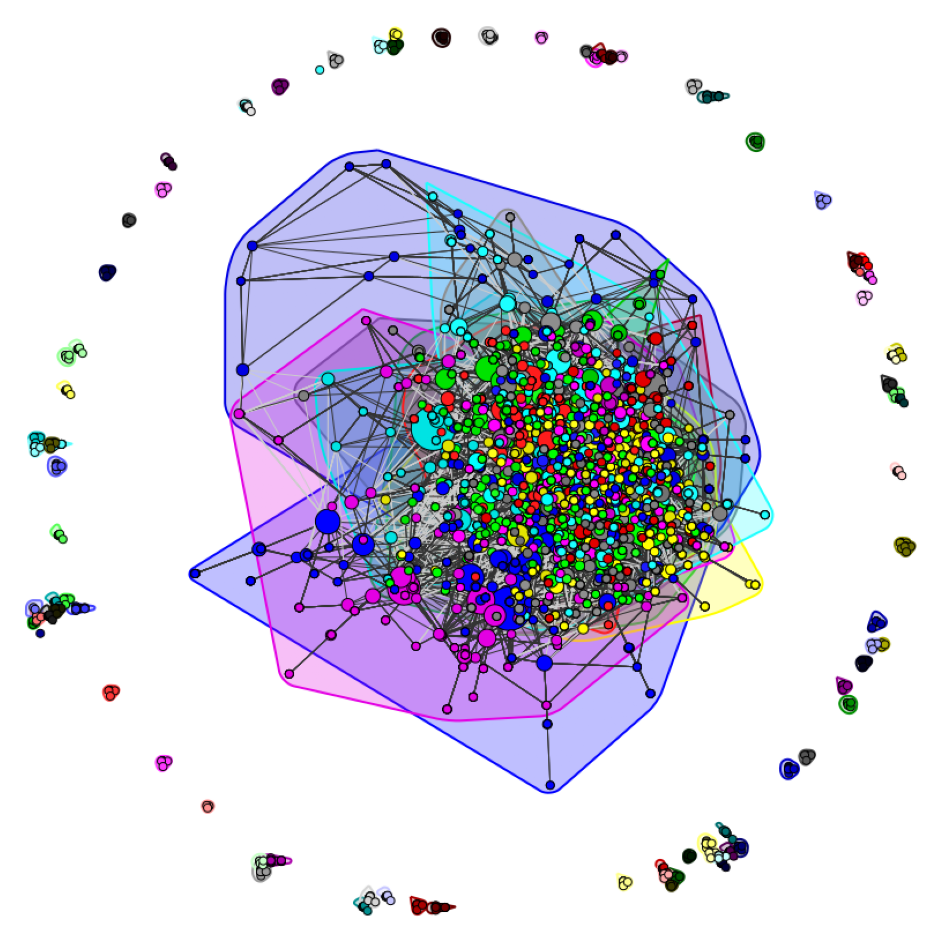

In [ ]:
## plot leiden
cluster_plot(graph_dramas, g_leiden_dramas_1, "mds", 800, "images/g_leiden_mds_dramas.png")